In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np 
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


- I want the ML to take as input 17 parameters corresponding to $[ \{ \alpha_i \}, \Omega_m, \Omega_m h^2 ]$ and to output the luminosity distance of the SN as a function of z, i.e. $d_L(z)$.
- In practice what I want is the ML to output an array of $d_L$, one of every bin in z. Therefore: $input = 1 \times 17$ and $output=1 \times N_{zbins}$.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.manual_seed(42)

In [4]:
def load_data_as_tensors(filename):
    keys = []
    values = []
    with h5py.File(filename, 'r') as hf:
        for group_name in hf.keys():
            key = hf[group_name]['input_cosmo'][:]
            value = hf[group_name]['LogdL'][:]
            keys.append(key)
            values.append(value)

    keys = np.array(keys)
    values = np.array(values)
    
    # Convert lists to PyTorch tensors
    train_x = torch.tensor(keys, dtype=torch.float32)  # Assuming keys are numeric
    train_y = torch.tensor(values, dtype=torch.float32)
    
    return train_x, train_y

In [5]:
# data_x is a tensor that contains all the cosmo parameter input vectors
# data_y is a tensor that contains all the output of logdL for each redshift bin and each combination of cosmo param input

data_x, data_y = load_data_as_tensors('LogdL_trial.h5')
dataset = TensorDataset(data_x, data_y)

In [6]:
## Split the data into training, validation and testing sets
total_size = len(dataset)
train_size = int(0.7 * total_size)  
val_size = int(0.2 * total_size)    
test_size = total_size - train_size - val_size  

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

In [7]:
## Before I use the data for training, I need to normalize it.
# Extract training data
train_loader1 = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
train_data_x, train_data_y = next(iter(train_loader1))

# Calculate mean and standard deviation
# x corresponds to the cosmological parameters which is the input in my model
# y corresponds to the "labels/targets" which is the logdL for each redshift bin
train_mean_x = train_data_x.mean(dim=0)
train_std_x = train_data_x.std(dim=0)

train_mean_y = train_data_y.mean(dim=0)
train_std_y = train_data_y.std(dim=0)

# Define a function to normalize data using mean and std
def normalize_data(data, mean, std):
    return (data - mean) / std

# Normalize the datasets
train_data_x = normalize_data(train_data_x, train_mean_x, train_std_x)
train_data_y = normalize_data(train_data_y, train_mean_y, train_std_y)

# Repeat for validation and test datasets
val_loader1 = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
val_data_x, val_data_y = next(iter(val_loader1))
val_data_x = normalize_data(val_data_x, train_mean_x, train_std_x)
val_data_y = normalize_data(val_data_y, train_mean_y, train_std_y)

test_loader1 = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_data_x, test_data_y = next(iter(test_loader1))
test_data_x = normalize_data(test_data_x, train_mean_x, train_std_x)
test_data_y = normalize_data(test_data_y, train_mean_y, train_std_y)

# Create new datasets with normalized data
train_dataset_normalized = TensorDataset(train_data_x, train_data_y)
val_dataset_normalized = TensorDataset(val_data_x, val_data_y)
test_dataset_normalized = TensorDataset(test_data_x, test_data_y)

# Create data loaders for each dataset
## Split in batches
batch_size = 32
train_loader = DataLoader(train_dataset_normalized, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_normalized, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_normalized, batch_size=batch_size, shuffle=False)

In [8]:
## Here I define an affine layer which will take care of the data normalization. 

class Affine(nn.Module):
    def __init__(self):
        super(Affine,self).__init__()
        self.gain = nn.Parameter(torch.ones(1))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return self.gain * x + self.bias
        

In [9]:
## Residual block - following the diagram in original ref: https://arxiv.org/pdf/1512.03385
## Each block will have two linear layers.
## The second activation is applied after I sum with the skip connection: ACT( F(x) + x )
class ResBlock(nn.Module):
    def __init__(self, in_size, out_size):
        super(ResBlock,self).__init__()
        if in_size != out_size:
            self.skip = nn.Linear(in_size, out_size, bias=False)
        else:
            self.skip = nn.Identity()
            
        self.linear1 = nn.Linear(in_size, out_size)
        self.linear2 = nn.Linear(out_size, out_size)

        self.norm1 = Affine()
        self.norm2 = Affine()

        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        
    def forward(self,x):
        xskip = self.skip(x)
        # x = self.act1(self.norm1(self.linear1(x)))
        # x = self.norm2(self.linear2(x))
        
        x = self.act1(self.linear1(self.norm1(x)))
        x = self.linear2(self.norm2(x))
        
        out = self.act2(x + xskip)
        return out
        
        

- Be careful with the definition of ModuleList. .modules() is a function defined under the class nn.Module, so I cannot reuse that name for a different method in my class definition.

In [10]:
class ResMLP(nn.Module):
    def __init__(self, input_dim, output_dim, block_nums):
        super(ResMLP,self).__init__()
        
        # Pytorch list that saves the different layers. These layers are not connected in a NN yet.
        # self.modules = nn.ModuleList()
        
        # Activation function to use
        self.act = nn.ReLU()
        
        # self.block = ResBlock(input_dim, input_dim)
        # Write a for loop that controls how many ResBlocks I include in my full network
        # for i in range(block_nums):
        #     self.modules.append(self.block)
        
        self.mymodules = nn.ModuleList([ResBlock(input_dim, input_dim) for _ in range(block_nums)])   
        
        # The last layer I append in the nn.ModuleList is the fully connected linear layer (output layer of my NN)
        self.mymodules.append(nn.Linear(input_dim, output_dim))
        
    def forward(self,x):
        ## I need to add one layer here to embed my input vector to the bigger internal space 
        # Connect the different blocks in the NN
        for block in self.mymodules[:-1]:
            x = self.act(block(x))
        # Pass the output through the final fully connected linear layer
        out = self.mymodules[-1](x)
        
        return out                 


In [11]:
## Training 
model = ResMLP(4,500,2)
model.to(device)
epochs = 50
train_losses = []
val_losses = []
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4)

In [12]:
for data, labels in train_loader:
    data, labels = data.to(device), labels.to(device)
    outputs = model(data)
    print(criterion(outputs,labels))
    break

tensor(1.1824, device='cuda:0', grad_fn=<MseLossBackward0>)


In [13]:
# ## Printing the initialization values of weights and biases
# def print_initial_parameters(model):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print(f"Parameter: {name}, Initial value: {param.data}")

# print_initial_parameters(model)


In [14]:
for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)  
        loss = criterion(outputs, labels)       
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
        # Check gradients for NaNs
        nan_found = False
        for name, param in model.named_parameters():
            if param.grad is not None:
                if torch.isnan(param.grad).any():
                    print(f"NaNs found in gradients of {name} during training")
                    nan_found = True
                    break
        
        if nan_found:
            continue
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * data.size(0)
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [10/500], Train Loss: 1.2442, Val Loss: 1.2092
Epoch [20/500], Train Loss: 1.2379, Val Loss: 1.2029
Epoch [30/500], Train Loss: 1.2320, Val Loss: 1.1970
Epoch [40/500], Train Loss: 1.2264, Val Loss: 1.1914
Epoch [50/500], Train Loss: 1.2212, Val Loss: 1.1862
Epoch [60/500], Train Loss: 1.2162, Val Loss: 1.1812
Epoch [70/500], Train Loss: 1.2115, Val Loss: 1.1765
Epoch [80/500], Train Loss: 1.2071, Val Loss: 1.1721
Epoch [90/500], Train Loss: 1.2028, Val Loss: 1.1678
Epoch [100/500], Train Loss: 1.1988, Val Loss: 1.1638
Epoch [110/500], Train Loss: 1.1950, Val Loss: 1.1600
Epoch [120/500], Train Loss: 1.1914, Val Loss: 1.1563
Epoch [130/500], Train Loss: 1.1879, Val Loss: 1.1528
Epoch [140/500], Train Loss: 1.1846, Val Loss: 1.1495
Epoch [150/500], Train Loss: 1.1814, Val Loss: 1.1463
Epoch [160/500], Train Loss: 1.1784, Val Loss: 1.1432
Epoch [170/500], Train Loss: 1.1754, Val Loss: 1.1403
Epoch [180/500], Train Loss: 1.1727, Val Loss: 1.1375
Epoch [190/500], Train Loss: 1.1700, 

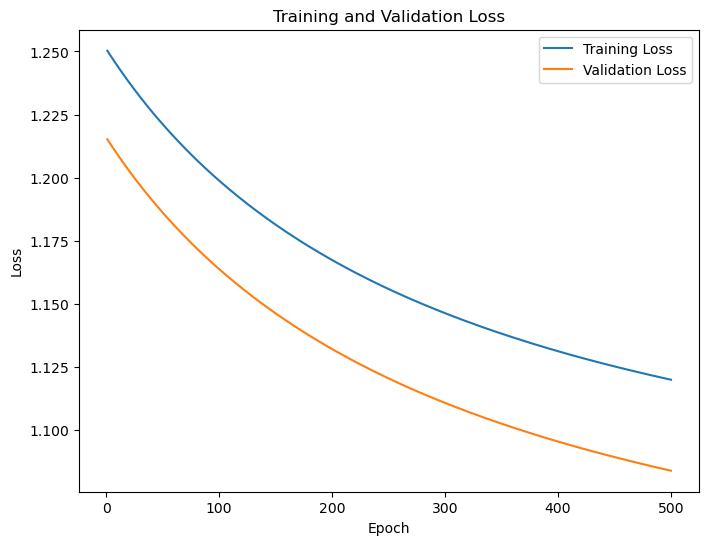

In [15]:
# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()